In [65]:
"""
CF-PDE system on a ciruclar domain
Model is:

ct = bete*w/(b + w)*c*(1-c-f) - dc*c + Dc Lap(c)
ft = beta(1 - w/(b + w))*f*(1-c-f) - df*f + Df Lap(f)
wt = lambda - mu*w - eta*c*w + Dw Lap(w)

Want to have Dirichlet BC for oxygen and no-flow
for c and f

"""

from __future__ import print_function
from fenics import *
from mshr import *
from dolfin import *
import numpy as np
import sys

T = 20.0            # final time
num_steps = 1000    # number of time steps
dt = T / num_steps # time step size
k = Constant(dt)

# CF params
beta = 5.0
b = 1.
n = 1.0
dc = 0.1
df = 0.1
q = 0.5
eta = .5
Dc = 4e-6
Df = 4e-4
Dw = 0.5e-1
w_r = 1.0

beta = Constant(beta)
b = Constant(b)
n = Constant(n)
dc = Constant(dc)
df = Constant(df)
q = Constant(q)
eta = Constant(eta)
Dc = Constant(Dc)
Df = Constant(Df)
Dw = Constant(Dw)
w_r = Constant(w_r)

# Read mesh from file
# mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')
L = 3.8
# L = float(sys.argv[1])
nx = ny = 30
# mesh = RectangleMesh(Point(-L, -L), Point(L, L), nx, ny)
domain = Circle(Point(0, 0), L)
mesh = generate_mesh(domain, nx)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define boundary condition for oxygen
def boundary(x, on_boundary):
    return on_boundary

# v.sub(2) puts a dirichlet BC only on the
# third component (oxygen)
bc = DirichletBC(V.sub(2), w_r, boundary)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
u = Function(V)
u_n = Function(V)

# Guasian ICs for C and F
u_0 = Expression(('0.4*exp(-1*pow(x[0], 2) - 1*pow(x[1], 2))','0.2*exp(-1*pow(x[0], 2) - 1*pow(x[1], 2))','1.0'), degree = 2, L=L)
u_n = interpolate(u_0, V)

# # Constant initial conditions for checking against ODE
# u_0 = Expression(('0.4','0.3','0.1'), degree = 2)
# u_n = interpolate(u_0, V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)


# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx  \
  + Dc*dot(grad(u_1), grad(v_1))*dx - (beta/( b + u_3 ))*u_3*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx  \
  + Df*dot(grad(u_2), grad(v_2))*dx - beta*(1 - u_3/( b + u_3 ))*u_2*(1-u_1-u_2)*v_2*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx  \
  + Dw*dot(grad(u_3), grad(v_3))*dx + eta*u_1*u_3*v_3*dx

# # Define variational problem
# F = ((u_1 - u_n1) / k)*v_1*dx  \
#   + Dc*dot(grad(u_1), grad(v_1))*dx - (pow(beta,n)/( pow(b,n) + pow(u_3,n) ))*pow(u_3,n)*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
#   + ((u_2 - u_n2) / k)*v_2*dx  \
#   + Df*dot(grad(u_2), grad(v_2))*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  - pow(beta,n)*(1 - pow(u_3,n)/( pow(b,n) + pow(u_3,n) ))*u_2*(1-u_1-u_2)*v_2*dx  \
#   + ((u_3 - u_n3) / k)*v_3*dx  \
#   + Dw*dot(grad(u_3), grad(v_3))*dx - _lambda*v_3*dx + mu*u_3*v_3*dx + eta*u_1*u_3*v_3*dx



# Create VTK files for visualization output
vtkfile_u_1 = File('cf_sys/u_1.pvd')
vtkfile_u_2 = File('cf_sys/u_2.pvd')
vtkfile_u_3 = File('cf_sys/u_3.pvd')

# Create progress bar
# progress = Progress('Time-stepping')
# set_log_level(PROGRESS)
progress = Progress('Time-stepping', num_steps)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    # timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u, bc)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    set_log_level(LogLevel.PROGRESS)
    progress += 1

# Hold plot
#interactive()

### write out function values for anaerobic population
u_1, u_2, u_3 = split(u)

# outfile = open('cf_sys/u out.txt','w')
      
# outfile.close()

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.624e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.262e-01 (tol = 1.000e-10) r (rel) = 3.415e-03 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 7.596e-05 (tol = 1.000e-10) r (rel) = 1.147e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 3: r (abs) = 2.297e-11 (tol = 1.000e-10) r (rel) = 3.468e-13 (tol = 1.000e-09)
    Newton solver finished

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.552e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.399e-05 (tol = 1.000e-10) r (rel) = 4.122e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.362e-11 (tol = 1.000e-10) r (rel) = 8.772e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [>                                                    ] 1.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Ja

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.770e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.090e-05 (tol = 1.000e-10) r (rel) = 4.005e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.487e-11 (tol = 1.000e-10) r (rel) = 8.400e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=>                                                   ] 2.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Ja

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.928e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.539e-05 (tol = 1.000e-10) r (rel) = 3.910e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.574e-11 (tol = 1.000e-10) r (rel) = 8.162e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=>                                                   ] 3.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newt

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.102e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.970e-05 (tol = 1.000e-10) r (rel) = 3.791e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.655e-11 (tol = 1.000e-10) r (rel) = 7.872e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.225e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.212e-05 (tol = 1.000e-10) r (rel) = 3.691e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.692e-11 (tol = 1.000e-10) r (rel) = 7.608e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===>                                                 ] 5.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newt

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.329e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.393e-05 (tol = 1.000e-10) r (rel) = 3.603e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.720e-11 (tol = 1.000e-10) r (rel) = 7.384e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.338e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.413e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.548e-05 (tol = 1.000e-10) r (rel) = 3.542e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.748e-11 (tol = 1.000e-10) r (rel) = 7.242e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

    Newton iteration 0: r (abs) = 2.490e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.718e-05 (tol = 1.000e-10) r (rel) = 3.501e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.780e-11 (tol = 1.000e-10) r (rel) = 7.147e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.497e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Kry

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.574e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.933e-05 (tol = 1.000e-10) r (rel) = 3.471e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.827e-11 (tol = 1.000e-10) r (rel) = 7.099e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.647e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.107e-05 (tol = 1.000e-10) r (rel) = 3.441e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.861e-11 (tol = 1.000e-10) r (rel) = 7.031e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.702e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.194e-05 (tol = 1.000e-10) r (rel) = 3.403e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.866e-11 (tol = 1.000e-10) r (rel) = 6.905e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [======>                                              ] 12.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.746e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.230e-05 (tol = 1.000e-10) r (rel) = 3.361e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.862e-11 (tol = 1.000e-10) r (rel) = 6.779e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.783e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.249e-05 (tol = 1.000e-10) r (rel) = 3.323e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.855e-11 (tol = 1.000e-10) r (rel) = 6.666e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=======>                                             ] 14.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.812e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.277e-05 (tol = 1.000e-10) r (rel) = 3.298e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.850e-11 (tol = 1.000e-10) r (rel) = 6.579e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Time-stepping [========>                                            ] 16.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.844e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.333e-05 (tol = 1.000e-10) r (rel) = 3.282e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.856e-11 (tol = 1.000e-10) r (rel) = 6.528e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.877e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.417e-05 (tol = 1.000e-10) r (rel) = 3.273e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.859e-11 (tol = 1.000e-10) r (rel) = 6.462e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.880e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  Time-stepping [==========>                                          ] 19.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.910e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.518e-05 (tol = 1.000e-10) r (rel) = 3.270e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.871e-11 (tol = 1.000e-10) r (rel) = 6.430e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.935e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.597e-05 (tol = 1.000e-10) r (rel) = 3.270e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.877e-11 (tol = 1.000e-10) r (rel) = 6.394e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.956e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.644e-05 (tol = 1.000e-10) r (rel) = 3.263e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.879e-11 (tol = 1.000e-10) r (rel) = 6.358e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===========>                                         ] 21.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

KeyboardInterrupt: 

  Object cannot be plotted directly, projecting to piecewise linears.
  Solving linear system of size 1877 x 1877 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 1877 x 1877 system.


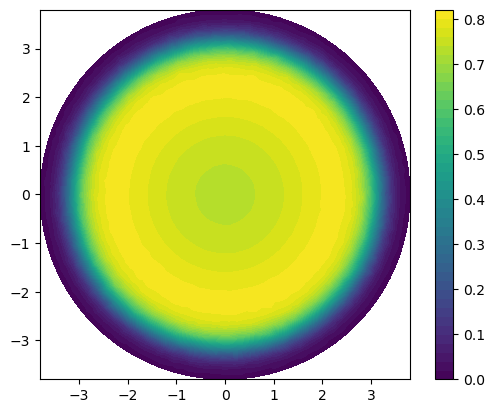

In [66]:
import matplotlib.pyplot as plt
fig = plot(u[0])
plt.colorbar(fig)

In [ ]:
dt

In [ ]:
c = u[0]
f = u[1]

In [ ]:
f([0,0])

mesh

In [67]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_repr_html_',
 '_repr_svg_',
 '_ufl_domain',
 'bounding_box_tree',
 'cell_name',
 'cell_orientations',
 'cells',
 'color',
 'coordinates',
 'data',
 'domains',
 'geometric_dimension',
 'geometry',
 'hash',
 'hmax',
 'hmin',
 'id',
 'init',
 'init_cell_orientations',
 'init_global',
 'label',
 'mpi_comm',
 'name',
 'num_cells',
 'num_edges',
 'num_entities',
 'num_entities_global',
 'num_faces',
 'num_facets',
 'num_vertices',
 'order',
 'ordered',
 'parameters',
 'rename',
 'rmax',
 'rmin',
 'rotate',
 'scale',
 'smooth',
 'smooth_boundary',
 'snap_boundary',
 'topology',
 'translate',
 'type',
 'ufl_cell',
 'ufl_coordinate_element',
 '

In [ ]:
V = FunctionSpace(mesh, "CG", 2)

In [ ]:
V
dof_coordinates = V.tabulate_dof_coordinates()

In [ ]:
dof_coordinates

In [ ]:
uh = Function(V)
expr = u[2]

In [ ]:
xyz = V.tabulate_dof_coordinates()

In [ ]:
x = xyz[:,0]

In [ ]:
f0 = f([0,0])
f0

In [ ]:
f0 > 0

In [ ]:
tol = 1e-3

In [ ]:
f0 > tol

In [ ]:
u[2]([0,0])

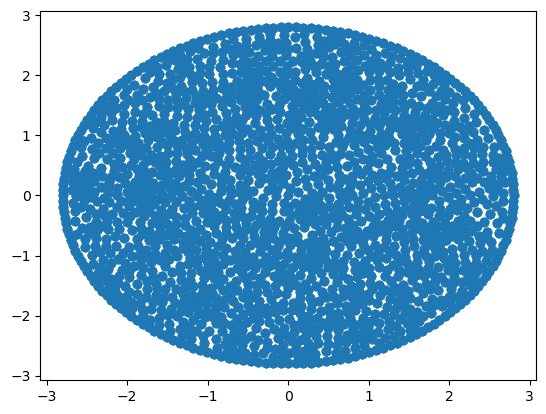

In [68]:
plt.scatter(dof_coordinates[:,0],dof_coordinates[:,1])

In [ ]:
dof_coordinates[:,0]

In [ ]:
u[1](dof_coordinates[55])

In [ ]:
dof_coordinates[1]

In [ ]:
u[1]([0,0])

In [ ]:
L

In [ ]:
c([3.8,0])

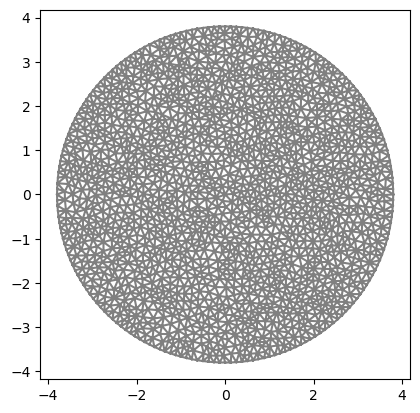

In [69]:
plot(mesh)

In [ ]:
2+2